In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define Domain
# Space
Xpts = int(1e2)  # Grid Points
X0, Xf = 0, 10  # Domain
Xlng = Xf-X0
x = np.linspace(X0, Xf, num=Xpts, endpoint=False)  # Spatial Domain
dx = Xlng/Xpts  # Grid Size

# Time
Tpts = int(5e2)  # Time Steps
T0, Tf = 0, 1  # Domain
Tlng = Tf-T0
snaps = 10  # Captured Time Steps
t = np.linspace(T0, Tf, num=snaps+1)
dt = Tlng/Tpts  # Time Step Size

# Numerical Parameters
xx, tt = np.meshgrid(x,t, sparse=False, indexing='xy') # Spatial-Temporal Domain
lmbd = dt / dx
n_0 = 3 / (4 * np.pi)
Gamma_0 = 1 # input("Enter Gamma_0: ")
kappa_0 = 1 # input("Enter kappa_0: ")
beta = 1

# Correlation Parameters
k_fft_norm = 2 * np.pi / (Xpts * dx)
k = k_fft_norm * np.linspace(-Xpts / 2, Xpts / 2 - 1, Xpts)  # Fourier Domain
x3 = np.linspace(-Xlng, 2 * Xlng, 3 * Xpts - 2)  # Correlation Domain

In [2]:
def memoryPDE(u_IC):
    u = np.zeros((2,Xpts))
    u[:] = np.copy(u_IC)
    uL = np.roll(u, 1, axis=1)
    FuL = np.zeros((2,Xpts))
    FuR = np.zeros((2,Xpts))
    u_tot = np.zeros((snaps+1, 2, Xpts))
    u_tot[0] = np.copy(u)
    return uL, u, FuL, FuR, u_tot

def solve_phic(unc, uphic):
    Ac = np.zeros(Xpts)
    # Define b
    bc = 3 - 4 * np.pi * dx * dx * unc
    bc = bc - np.mean(bc)
    # First sweep
    Ac[0] = -0.5
    bc[0] = -0.5 * bc[0]
    for ii in range(1, Xpts):
        Ac[ii] = -1 / (2 + Ac[ii - 1])
        bc[ii] = (bc[ii - 1] - bc[ii]) / (2 + Ac[ii - 1])
    # Second sweep
    uphic[0] = bc[Xpts - 1] - bc[Xpts - 2]
    for ii in range(1, Xpts - 1):
        uphic[ii] = (bc[ii - 1] - uphic[ii - 1]) / Ac[ii - 1]
    return uphic

def memoryODE(un):
    u = np.zeros((2,Xpts))
    for c in range(2):
        u[c] = solve_phic(un[c], u[c])
    uL = np.roll(u, 1, axis=1)
    u_tot = np.zeros((snaps+1, 2, Xpts))
    u_tot[0] = np.copy(u)
    return uL, u, u_tot

In [3]:
# Initial Conditions
disp_freq = 3 * 2 * np.pi / Xlng
n_IC = n_0 * np.ones(Xpts) + .01 * np.sin(disp_freq * x)
v_IC = - .01 #* np.sin(disp_freq * x)
# v_IC = np.zeros(Xpts)
# n_IC = n_0 * np.ones(Xpts) + .01 * (np.random.rand(Xpts)-.5)
# v_IC = .01 * (np.random.rand(Xpts)-.5)

# Memory Allocation
nL, n, FnL, FnR, n_tot = memoryPDE(n_IC)
vL, v, FvL, FvR, v_tot = memoryPDE(v_IC)
phiL, phi, phi_tot = memoryODE(n)
rhs = np.zeros((2,Xpts))

vec = np.stack((n,v))
vecL = np.roll(vec, 1, axis=1)
vec_tot = np.stack((n_tot, v_tot))

In [4]:
# =============== #
# Solve Functions #
# =============== #
def test_flux(unc, uvc): # Inputs - n[c],v[c] / Output - flux_n_c, flux_v_c
    # TODO: Save memory by taking flux_n, flux_v out of function; define static array of fluxes.
    #       Fluxes will depend on current values of n,v which will already update in Solve loop
    flux_unc = np.zeros(Xpts)
    flux_uvc = np.zeros(Xpts)
    for ii in range(Xpts):
        flux_unc[ii] = unc[ii]*uvc[ii]
        flux_uvc[ii] = .5*uvc[ii]*uvc[ii]+np.log(unc[ii])
    godunov_flux = np.stack((flux_unc, flux_uvc))
    return godunov_flux
    

def flux(unc, uvc): # Inputs - n[c],v[c] / Output - flux_n_c, flux_v_c
    # TODO: Save memory by taking flux_n, flux_v out of function; define static array of fluxes.
    #       Fluxes will depend on current values of n,v which will already update in Solve loop
    uvec = np.stack((unc,uvc))
    uvec_L = np.roll(uvec,1)
    flux_unc = np.multiply(unc, uvc)
    flux_uvc = .5*np.multiply(uvc, uvc)+np.log(unc)
    uvec_flux = np.stack((flux_unc, flux_uvc))
    uvec_flux_L = np.roll(uvec_flux, 1)
    
    godunov_flux = np.zeros((2,Xpts))
    for eq in range(2): # Iterate over system
        for ii in range(Xpts): # Iterate over spacial values
            if uvec_L[eq,ii] > uvec[eq,ii]:
                godunov_flux[eq,ii] = np.maximum(uvec_flux_L[eq,ii], uvec_flux[eq,ii])
            elif uvec_L[eq,ii] < uvec[eq,ii]:
                godunov_flux[eq,ii] = np.minimum(uvec_flux_L[eq,ii], uvec_flux[eq,ii])
            else:
                godunov_flux[eq,ii] = 0.0

    godunov_flux = uvec_flux
    return godunov_flux

def sys_to_vec(unc, uvc):
    uveccR = np.stack((nc,vc))
    uveccL = np.roll(vec, 1, axis=1)
    return uveccL, uveccR
    
def vec_to_sys(uvecc):
    unRc = np.copy(vec[0,c])
    unLc = np.roll(unRc,1)
    uvRc = np.copy(vec[1,c])
    uvLc = np.roll(uvRc,1)
    return unLc, unRc, uvLc, uvRc

1


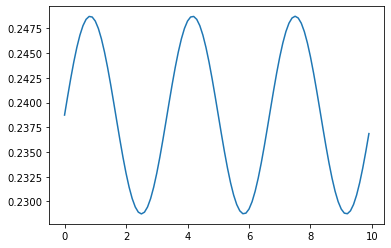

2


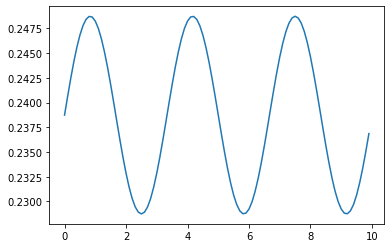

3


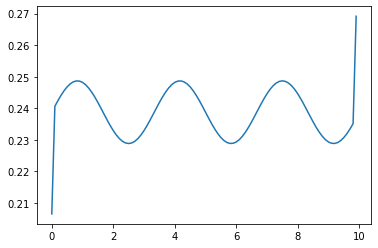

4


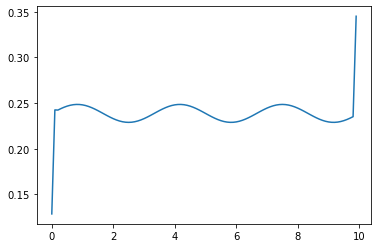

5


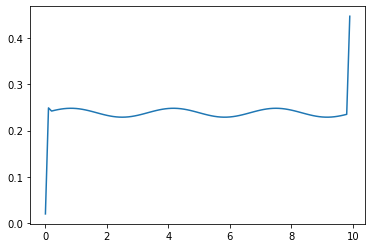

6


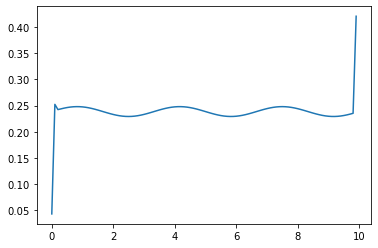

7


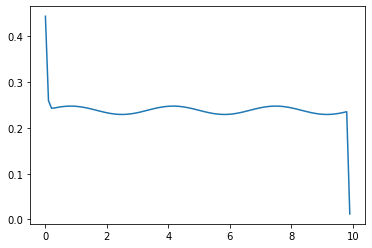

8


<ipython-input-4-8d0177d9768e>:22: RuntimeWarning: invalid value encountered in log
  flux_uvc = .5*np.multiply(uvc, uvc)+np.log(unc)


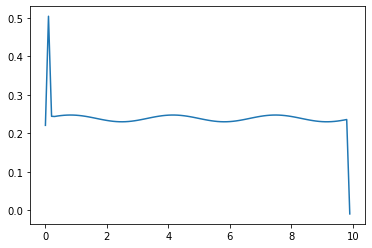

<ipython-input-4-8d0177d9768e>:22: RuntimeWarning: invalid value encountered in log
  flux_uvc = .5*np.multiply(uvc, uvc)+np.log(unc)


9


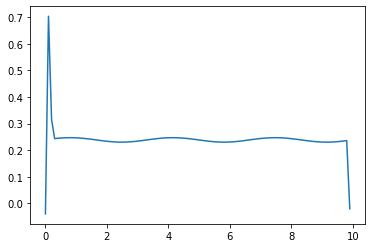

<ipython-input-4-8d0177d9768e>:22: RuntimeWarning: invalid value encountered in log
  flux_uvc = .5*np.multiply(uvc, uvc)+np.log(unc)


In [5]:
# ===== #
# Solve #
# ===== #
for c in range(2): # Iterate through correlations
    cur_snap = 0
    for tt in range(1,Tpts): # Iterate Time
        
        sys_Flux = flux(n[c], v[c])      
        Fn = sys_Flux[0]
        Fv = sys_Flux[1]

        if tt < 10 and c == 0:
            print(tt)
            plt.plot(x,n[c],label="n")
#             plt.plot(x,v[c],label="v")
            plt.show(block=False)

#             print("n", '%s' % float('%.3g' % n[c,-1]), '%s' % float('%.3g' % n[c,0]), '%s' % float('%.3g' % n[c,1]),
#                   '%s' % float('%.3g' % n[c,2]), '%s' % float('%.3g' % n[c,3]), '%s' % float('%.3g' % n[c,4]),
#                   '%s' % float('%.3g' % n[c,5]), '%s' % float('%.3g' % n[c,6]), '%s' % float('%.3g' % n[c,7]),
#                   '%s' % float('%.3g' % n[c,8]), '%s' % float('%.3g' % n[c,9]), '%s' % float('%.3g' % n[c,10]))
# #             print("v", '%s' % float('%.3g' % v[c,-1]), '%s' % float('%.3g' % v[c,0]), '%s' % float('%.3g' % v[c,1]),
# #                   '%s' % float('%.3g' % v[c,2]), '%s' % float('%.3g' % v[c,3]), '%s' % float('%.3g' % v[c,4]),
# #                   '%s' % float('%.3g' % v[c,5]), '%s' % float('%.3g' % v[c,6]), '%s' % float('%.3g' % n[c,7]),
# #                   '%s' % float('%.3g' % n[c,8]), '%s' % float('%.3g' % n[c,9]), '%s' % float('%.3g' % v[c,10]))
#             print("Fn", '%s' % float('%.3g' % Fn[-1]), '%s' % float('%.3g' % Fn[0]), '%s' % float('%.3g' % Fn[1]),
#                   '%s' % float('%.3g' % Fn[2]), '%s' % float('%.3g' % Fn[3]), '%s' % float('%.3g' % Fn[4]),
#                   '%s' % float('%.3g' % Fn[5]), '%s' % float('%.3g' % Fn[6]), '%s' % float('%.3g' % Fn[7]),
#                   '%s' % float('%.3g' % Fn[8]), '%s' % float('%.3g' % Fn[9]), '%s' % float('%.3g' % Fn[10]))
#             print("Fv", '%s' % float('%.3g' % Fv[-1]), '%s' % float('%.3g' % Fv[0]), '%s' % float('%.3g' % Fv[1]),
#                   '%s' % float('%.3g' % Fv[2]), '%s' % float('%.3g' % Fv[3]), '%s' % float('%.3g' % Fv[4]),
#                   '%s' % float('%.3g' % Fv[5]), '%s' % float('%.3g' % Fv[6]), '%s' % float('%.3g' % Fv[7]),
#                   '%s' % float('%.3g' % Fv[8]), '%s' % float('%.3g' % Fv[9]), '%s' % float('%.3g' % Fv[10]))
# #             print("n*v", '%s' % float('%.3g' % (n[c,-1]*v[c,-1])), '%s' % float('%.3g' % (n[c,0]*v[c,0])), '%s' % float('%.3g' % (n[c,1]*v[c,1])))

#         n[c,0] = n[c,Xpts-1]
#         v[c,0] = v[c,Xpts-1]
#         for ii in range(1,Xpts):
#             n[c,ii] = n[c,ii]-lmbd*Fn[ii]
#             v[c,ii] = v[c,ii]-lmbd*Fv[ii]

        rhs[c] = -Gamma_0*(phi[c] - np.roll(phi[c],1))/dx
        
        for ii in range(0,Xpts):
            n[c,ii] = n[c,ii]-lmbd*(Fn[ii]-Fn[ii-1])
            v[c,ii] = v[c,ii]-lmbd*(Fv[ii]-Fv[ii-1])+rhs[c,ii]

        phi[c] = solve_phic(n[c],phi[c])
        
        #  Snapshot
        if tt % (Tpts/snaps) == 0:
            cur_snap += 1
            n_tot[cur_snap,c] = n[c]
            v_tot[cur_snap,c] = v[c]
            phi_tot[cur_snap,c] = phi[c]

In [6]:
# ============== #
# Plot Functions #
# ============== #
def plot(ux, u_tot):
    for c in range(2):
        fig = plt.figure(figsize=(15,15))
        plt.title("Plot")    
        for asnap in range(snaps+1):
            plt.plot(ux, u_tot[asnap,c], label=str(asnap/snaps))
        plt.legend()
    plt.show(block=False)

def cmap(ux, ut, u_tot): 
    for c in range(2):
        fig = plt.figure(figsize=(15,15))
        color_map = plt.contourf(ux, ut, u_tot[:,c])
        plt.colorbar()
        plt.ylabel("Time")
        plt.xlabel("Space")
        plt.show(block=False)    

def calculate_2dft(u_tot):
    fft = np.fft.ifftshift(u_tot-np.mean(u_tot[:,:]))
    fft = np.fft.fft2(fft)
    return np.abs(np.fft.fftshift(fft))

def disp_rel_cmap(ux, ut, u_tot):
    fft = calculate_2dft(u_tot)
    cmap(ux, ut, fft)
    
def subplot(u_tot):
    fig, axes = plt.subplots(nrows=3, ncols=3)
    # find minimum of minima & maximum of maxima
    minmin = np.min(u_tot[:,0],u_tot[:,1])
    maxmax = np.max(u_tot[:,0],u_tot[:,1])
    images = []
    for ii in range(3):
        for jj in range(3):
            im = axes[ii][jj].imshow(u_tot[ii+jj], vmin=minmin, vmax=maxmax,
                                     extent=(0,Xlng,0,t), aspect='auto', cmap='viridis')
            axes[ii][jj].set_title('Γ = ' + str(Gamma[ii]) + ', κ = ' + str(kappa[jj]))
            axes[ii][jj].set_ylabel("Time")
            axes[ii][jj].set_xlabel("Space")
            images.append(im)

    fig.tight_layout(pad = .01)
    fig.subplots_adjust(top=0.9)
    fig.suptitle("Density: Xptso Correlations")
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=1)
    plt.show(block=False)
    
def plot3D():
    fig = plt.figure()
    